# Training neural network to predict ball position in a 3d space
## 1. Importing Libraries

In [29]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from utils.evaluate import evaluate_model
from utils.plot_maker_gaussian_process import plot_maker_3d

## 2. Importing Data

In [30]:
# get all the red ball data
X_butterfly_a = pd.read_csv('../data_128px_wide/Butterfly/red_ball_coordinates_128px_2024-03-12_15h36m.csv', decimal='.', delimiter=',')
X_butterfly_b = pd.read_csv('../data_128px_wide/Butterfly/red_ball_coordinates_128px_2024-03-12_15h37m.csv', decimal='.', delimiter=',')
X_circle_a = pd.read_csv('../data_128px_wide/Circle/red_ball_coordinates_128px_2024-03-12_16h10m.csv', decimal='.', delimiter=',')
X_circle_b = pd.read_csv('../data_128px_wide/Circle/red_ball_coordinates_128px_2024-03-12_16h11m.csv', decimal='.', delimiter=',')
X_circle_c = pd.read_csv('../data_128px_wide/Circle/red_ball_coordinates_128px_2024-03-12_16h12m.csv', decimal='.', delimiter=',')
X_spiral_a = pd.read_csv('../data_128px_wide/Spiral/red_ball_coordinates_128px_2024-03-12_16h00m.csv', decimal='.', delimiter=',')
X_spiral_b = pd.read_csv('../data_128px_wide/Spiral/red_ball_coordinates_128px_2024-03-12_16h01m.csv', decimal='.', delimiter=',')
X_random_a = pd.read_csv('../data_128px_wide/Random/red_ball_coordinates_128px_2024-03-12_15h44m.csv', decimal='.', delimiter=',')

In [31]:
# get all the position data
y_butterfly_a = pd.read_csv('../data_128px_wide/Butterfly/positions_xyz_2024-03-12_15h36m.csv', decimal='.', delimiter=',').iloc[4:]
y_butterfly_b = pd.read_csv('../data_128px_wide/Butterfly/positions_xyz_2024-03-12_15h37m.csv', decimal='.', delimiter=',').iloc[4:]
y_circle_a = pd.read_csv('../data_128px_wide/Circle/positions_xyz_2024-03-12_16h10m.csv', decimal='.', delimiter=',').iloc[4:]
y_circle_b = pd.read_csv('../data_128px_wide/Circle/positions_xyz_2024-03-12_16h11m.csv', decimal='.', delimiter=',').iloc[4:]
y_circle_c = pd.read_csv('../data_128px_wide/Circle/positions_xyz_2024-03-12_16h12m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_a = pd.read_csv('../data_128px_wide/Spiral/positions_xyz_2024-03-12_16h00m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_b = pd.read_csv('../data_128px_wide/Spiral/positions_xyz_2024-03-12_16h01m.csv', decimal='.', delimiter=',').iloc[4:]
y_random_a = pd.read_csv('../data_128px_wide/Random/positions_xyz_2024-03-12_15h44m.csv', decimal='.', delimiter=',').iloc[4:]

#### 2.1 Check for Missing Values in spriral_down_b and spiral_down_c

In [32]:
print(f'The amount of NaN values in X_butterfly_a: {X_butterfly_a.isna().sum().sum()}')
print(f'The amount of NaN values in X_butterfly_b: {X_butterfly_b.isna().sum().sum()}')
print(f'The amount of NaN values in X_circle_a: {X_circle_a.isna().sum().sum()}')
print(f'The amount of NaN values in X_circle_b: {X_circle_b.isna().sum().sum()}')
print(f'The amount of NaN values in X_circle_c: {X_circle_c.isna().sum().sum()}')
print(f'The amount of NaN values in X_spiral_a: {X_spiral_a.isna().sum().sum()}')
print(f'The amount of NaN values in X_spiral_b: {X_spiral_b.isna().sum().sum()}')
print(f'The amount of NaN values in X_random_a: {X_random_a.isna().sum().sum()}')

The amount of NaN values in X_butterfly_a: 0
The amount of NaN values in X_butterfly_b: 2
The amount of NaN values in X_circle_a: 0
The amount of NaN values in X_circle_b: 0
The amount of NaN values in X_circle_c: 0
The amount of NaN values in X_spiral_a: 0
The amount of NaN values in X_spiral_b: 8
The amount of NaN values in X_random_a: 0


### 2.3 Combine all the datasets

In [33]:
X_train = pd.concat([X_butterfly_a, X_butterfly_b, X_circle_a, X_circle_b, X_circle_c, X_spiral_a, X_spiral_b, X_random_a])
y_train = pd.concat([y_butterfly_a, y_butterfly_b, y_circle_a, y_circle_b, y_circle_c, y_spiral_a, y_spiral_b, y_random_a])
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [34]:
X_train.shape, y_train.shape

((8525, 14), (8525, 3))

In [35]:
combined = pd.concat([X_train, y_train], axis=1)

## 3. Data Preprocessing

In [36]:
# check for missing values
print(f'The data has missing values: {combined.isnull().sum().sum()}')
combined.dropna(inplace=True)
print(f'The data has missing values: {combined.isnull().sum().sum()}')

The data has missing values: 10
The data has missing values: 0


In [37]:
X = combined.iloc[:, :14]
y = combined.iloc[:, 14:]

In [38]:
# scale the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## 4. Hyperparameter Tuning

In [39]:
# create a pipeline
pipeline = Pipeline([
    ('mlp', MLPRegressor(random_state=42))
])

In [52]:
param_grid = {
    'mlp__hidden_layer_sizes': [(50, 100, 50), (20, 40, 20)],
    'mlp__activation': ['identity', 'tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.001, 0.01, 0.1],
    'mlp__max_iter': [10000, 20000, 28000],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__early_stopping': [True],
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, n_iter=100, n_jobs=-1, verbose=3, random_state=42)

random_search.fit(X_scaled, y_scaled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
35 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\xande\venv\lib\site-

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('mlp',
                                              MLPRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'mlp__activation': ['identity', 'tanh',
                                                            'relu'],
                                        'mlp__alpha': [0.001, 0.01, 0.1],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50, 100,
                                                                     50),
                                                                    (20, 40,
                                                                     20)],
                                        'mlp__learning_rate': ['constant',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [10000, 20000, 28000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=42, verbose=3)

In [53]:
print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {random_search.best_score_}')

Best parameters: {'mlp__solver': 'adam', 'mlp__max_iter': 10000, 'mlp__learning_rate_init': 0.01, 'mlp__learning_rate': 'constant', 'mlp__hidden_layer_sizes': (20, 40, 20), 'mlp__early_stopping': True, 'mlp__alpha': 0.1, 'mlp__activation': 'tanh'}
Best score: -0.5145996479290625


In [42]:
model = random_search.best_estimator_

## 5. Training the Model

In [43]:
model.fit(X_scaled, y_scaled)

Pipeline(steps=[('mlp',
                 MLPRegressor(activation='tanh', alpha=0.1, early_stopping=True,
                              hidden_layer_sizes=(50, 100, 50),
                              learning_rate_init=0.01, max_iter=10000,
                              random_state=42))])

## 6. Make Predictions On Test Data

In [44]:
import pandas as pd

In [45]:
X_test_spiral = pd.read_csv('../data_128px_wide/Spiral/red_ball_coordinates_128px_2024-03-12_16h03m.csv', decimal='.', delimiter=',')[:200]
y_test_spiral = pd.read_csv('../data_128px_wide/Spiral/positions_xyz_2024-03-12_16h03m.csv', decimal='.', delimiter=',').iloc[4:][:200]

In [46]:
X_test_8 = pd.read_csv('../data_128px_wide/8-motion/red_ball_coordinates_128px_2024-03-12_15h32m.csv', decimal='.', delimiter=',')
y_test_8 = pd.read_csv('../data_128px_wide/8-motion/positions_xyz_2024-03-12_15h32m.csv', decimal='.', delimiter=',').iloc[4:]

In [47]:
def prepare_and_scale_test_data(X_test_val, y_test_val, scaler_x_test):
    y_test_val = y_test_val.iloc[4:]
    combined_test = pd.concat([X_test_val, y_test_val], axis=1)
    combined_test.dropna(inplace=True)
    X_val = combined_test.iloc[:, :14]
    y_val = combined_test.iloc[:, 14:]
    X_scaled_test = scaler_x_test.transform(X_val)
    return X_scaled_test, y_val

In [48]:
def predict_evaluate_plot(X_test_val_scaled, y_test_val, nn_model, scaler_y_test, title='Trajectory of Ball in 3D Space'):
    y_test_predicted_scaled = nn_model.predict(X_test_val_scaled)
    y_test_pred = scaler_y_test.inverse_transform(y_test_predicted_scaled)
    mse, mae, r2 = evaluate_model(y_test_val, y_test_pred, 'Test Data')
    # change col 1 and 2 from place, so it corresponds to the unity 3d space
    y_test_pred = y_test_pred[:, [0, 2, 1]]
    y_test_val = y_test_val.to_numpy()[:, [0, 2, 1]]
    plot_maker_3d(y_test_val, y_test_pred, title)
    return y_test_pred, mse, mae, r2

In [49]:
X_test_spiral_scaled, y_test_spiral = prepare_and_scale_test_data(X_test_spiral, y_test_spiral, scaler_x)

Mean Squared Error on Test Data Set: 0.5892956809581409
Mean Absolute Error on Test Data Set: 0.6415155960880708
R2 Score on Test Data set: -1.385672391442279


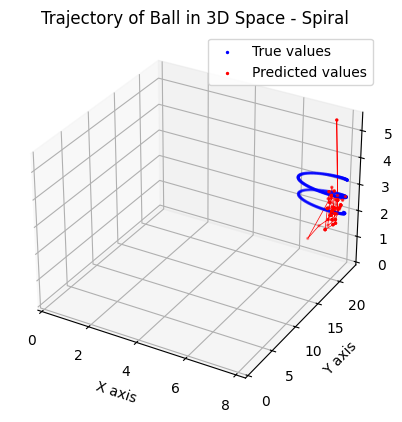

In [50]:
X_test_spiral_pred, mse_spiral, mae_spiral, r2_spiral = predict_evaluate_plot(X_test_spiral_scaled, y_test_spiral, model, scaler_y, title='Trajectory of Ball in 3D Space - Spiral')

Mean Squared Error on Test Data Set: 3.0060125614180406
Mean Absolute Error on Test Data Set: 1.3919131657007073
R2 Score on Test Data set: -0.6809334949372544


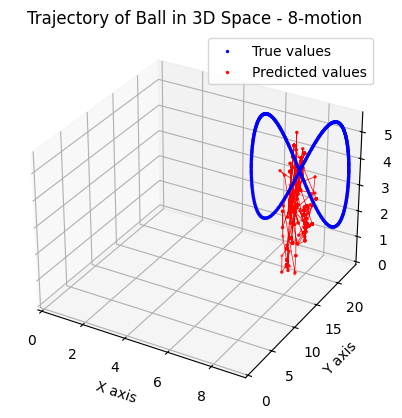

In [51]:
X_test_8_scaled, y_test_8 = prepare_and_scale_test_data(X_test_8, y_test_8, scaler_x)
X_test_8_pred, mse, mae, r2 = predict_evaluate_plot(X_test_8_scaled, y_test_8, model, scaler_y, title='Trajectory of Ball in 3D Space - 8-motion')